In [1]:
import sys
sys.path.append('../') 
import model
import torch
import time
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import numpy as np
import librosa
import matplotlib.pyplot as plt
import sounddevice as sd

def plot(fname):
    fs, before = wavfile.read(fname)
    before = before[:, 0]
    S_beofe = librosa.feature.melspectrogram(y=before, sr=fs)

    fs, after = wavfile.read('enhanced_' + fname)
    S_after = librosa.feature.melspectrogram(y=after, sr=fs)

    plt.subplot(2, 2, 1)
    plt.plot(before)
    plt.title('Input audio')
    plt.subplot(2, 2, 3)
    librosa.display.specshow(librosa.power_to_db(S_beofe, ref=np.max), y_axis='mel', sr=fs, x_axis='time')

    plt.subplot(2, 2, 2)
    plt.plot(after)
    plt.title('VibVoice output')
    plt.subplot(2, 2, 4)
    librosa.display.specshow(librosa.power_to_db(S_after, ref=np.max), y_axis='mel', sr=fs, x_axis='time')
    plt.show()
def inference_file(data_name = 'example1.wav'):
    device = 'cpu'
    checkpoint = torch.load('VibVoice_default.pt', map_location=torch.device(device))['model_state_dict']
    net = getattr(model, 'masker')('VibVoice_Early').to(device)
    net.eval() 
    net.load_state_dict(checkpoint, strict=True)

    if data_name is not None:
        _, data = wavfile.read(data_name)
        data = np.transpose(data)
        noisy = data[:1, :] * 4
        acc = data[1:, :] * 4

        b, a = signal.butter(4, 100, 'highpass', fs=16000)
        noisy = signal.filtfilt(b, a, noisy)
        acc = signal.filtfilt(b, a, acc)

        noisy = torch.from_numpy(noisy.copy()).to(dtype=torch.float)
        acc = torch.from_numpy(acc.copy()).to(dtype=torch.float)

        complex_stft = torch.stft(noisy, 640, 320, 640, window=torch.hann_window(640, device=noisy.device), return_complex=True).unsqueeze(0)
        noisy_mag, noisy_phase = torch.abs(complex_stft), torch.angle(complex_stft)
        complex_stft = torch.stft(acc, 640, 320, 640, window=torch.hann_window(640, device=acc.device), return_complex=True).unsqueeze(0)
        acc_mag = torch.abs(complex_stft)
    else:
        noisy_mag = torch.randn(1, 1, 321, 251).to(device)
        acc = torch.randn(1, 1, 321, 251).to(device)
    length = noisy_mag.shape[-1]

    real_time_output = []
    t_start = time.time()
    with torch.no_grad():
        for i in range(length):
            real_time_input1 = noisy_mag[:, :, :, i:i+1]
            real_time_input2 = acc_mag[:, :, :, i:i+1]
            real_time_output.append(net.forward_causal(real_time_input1, real_time_input2))
        full_output = net(noisy_mag, acc_mag)
    real_time_output = torch.cat(real_time_output, dim=-1)
    t_end = time.time()

    # measure whether real-time is different from full output
    error = torch.mean(torch.abs((full_output - real_time_output)/(full_output +1e-6)))
    print('Real-time difference ', error.item())

    # summary all the latency
    inference_latency_per_frame = round((t_end - t_start)/length ,4)
    load_latency_per_frame = 1/50
    overall_latency_per_frame = inference_latency_per_frame + load_latency_per_frame
    print('Latency:', round(overall_latency_per_frame,2), 'RTF:', round(inference_latency_per_frame/load_latency_per_frame, 2))

    # save as wav
    if data_name:
        real_time_output = real_time_output.squeeze()
        noisy_phase = noisy_phase.squeeze()
        features = torch.complex(real_time_output * torch.cos(noisy_phase), real_time_output * torch.sin(noisy_phase))
        est_audio = torch.istft(features, 640, 320, 640, window=torch.hann_window(640, device=features.device), length=None).cpu().numpy()
        wavfile.write('enhanced_' + data_name, 16000, est_audio)
        plot(data_name)

Real-time difference  4.0627071484777844e-07
Latency: 0.03 RTF: 0.32


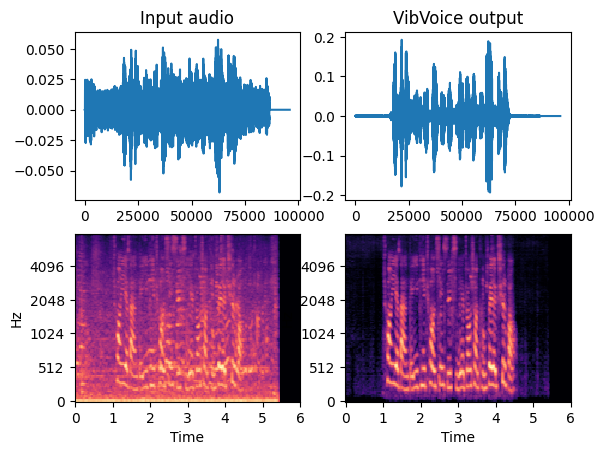

In [2]:
fname = 'example3.wav'
inference_file(fname)

Real-time difference  2.453805336699588e-07
Latency: 0.03 RTF: 0.34


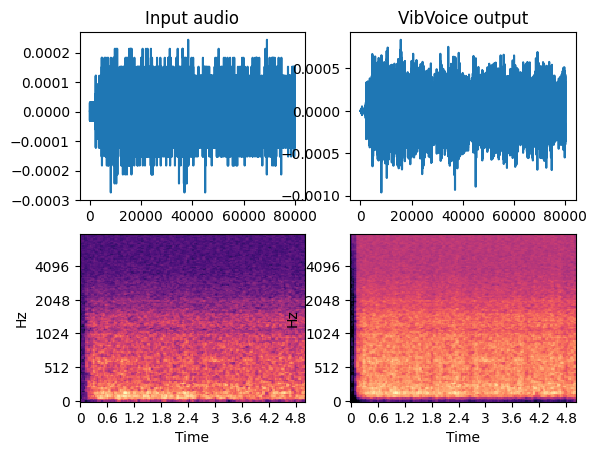

In [3]:
fname = 'online_recording.wav'
myrecording = sd.rec(16000*5, samplerate=16000, channels=2, blocking=True)
sd.wait()
vibration, audio = myrecording[0], myrecording[1]
vibration *= 4 # amplify the vibration
data = np.stack((audio, vibration)) 
wavfile.write(fname, 16000, myrecording)
inference_file(fname)
